# Mass Importation

In [ ]:
import pandas as pd
import numpy as np
import dateutil.parser
from datetime import date

from pprint import pprint
import re

from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import os

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

import pickle
import time

# Scraping From Main Steam Search Page
Able to Scrape:
   1. Game Title (*DataFrame Index*)
   2. Systems that the game runs on
   3. Release date of game in days
   4. Discount by numerical percent
   5. Price of Game
   6. Number of Reviews (**Dependent Variable**)

## Helper Functions
Function for parsing date elements in dataset

In [ ]:
def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

Function for creating list of links to parse

In [ ]:
links=['https://store.steampowered.com/search/']
for i in range(1,1954):
    links.append('https://store.steampowered.com/search/?page='+str(i))

## The Scrape

In [ ]:
'''
cols = ['title', 'link', 'system', 'systems', 'reviews', 'release_date', 'discount', 'price']
df=pd.DataFrame(columns=cols, index=[])

age=date.today()
for link in links:
    response=requests.get(link)
    soup = BeautifulSoup(response.text, 'html5lib')
    try: 
        main_search_table=soup.find('div', id='search_result_container').find_all('div')[1]
    except:
        time.sleep(20)
        main_search_table=soup.find('div', id='search_result_container').find_all('div')[1]
    print(link)
    for game in main_search_table.find_all('a'):
        row={}
        row['title']=game.find('span', class_="title").text #title
        row['link']=game['href'] #link
        systems=[system["class"][1] for system in game.find('p').find_all('span')] #system
        row['system']=len(systems)
        row['systems']=systems
        try:
            row['release_date']=(age-(to_date(game.find('div', class_="col search_released responsive_secondrow").text).date())).days #release date  
        except:
            row['release_date']=0
        for price in game.find_all('div', class_="col search_price_discount_combined responsive_secondrow"): #price and discount
            for discount in price.find_all('div', class_="col search_discount responsive_secondrow"):
                if discount.find('span'):
                    row['discount']=abs(int(discount.find('span').text.strip('%')))
                    try:
                        row['price']=float(price.find('span', style="color: #888888;").text.strip("$"))
                    except:
                        price = re.sub('[^0-9,.]','', game.find('div', class_="col search_price responsive_secondrow").text).replace("\n","").strip("\t")
                        row['price']=price
                else:
                    row['discount']=0
                    if not game.find('div', class_="col search_price responsive_secondrow").text.replace("\n","").strip("\t"):
                        row['price']=0
                    elif game.find('div', class_="col search_price responsive_secondrow").text.replace("\n","").strip("\t").lower()[0]!='$': #'free to play' or game.find('div', class_="col search_price responsive_secondrow").text.replace("\n","").strip("\t").lower()=='free':
                        row['price']=0
                    else:
                        row['price']=float(game.find('div', class_="col search_price responsive_secondrow").text.replace("\n","").strip("\t").strip("$"))  
        for y in game.find_all('div',class_="col search_reviewscore responsive_secondrow"):
            x=[review['data-tooltip-html'] for review in y.find_all('span')]
            if not x:
                row['reviews']=int(0)
            else:
                z=x[0].split('<br>')
                d=z[1].split(" ")
                row['reviews']=int(d[3].replace(',', '')) #reviews
        df=df.append(row, ignore_index=True)
        with open('steam_search.pkl', 'wb') as picklefile:
            pickle.dump(df, picklefile)
#     time.sleep(3)
    
df.set_index('title', inplace=True)
df.rename(columns=lambda x: x.strip())
pd.options.display.max_rows = 4000
'''

#Nofaith: Make copy of df from pickle and read into csv

In [5]:
!ls 

Untitled.ipynb         project_benson
all steam no sel.ipynb project_luther


In [1]:
# with open("steam_search.pkl", 'rb') as picklefile: 
#       df2 = pickle.load(picklefile)
# df2.to_csv('steam3.csv')
# df2

FileNotFoundError: [Errno 2] No such file or directory: 'steam_search.pkl'

Read in csv from previous scrape

In [ ]:
# df=pd.read_csv('steam3.csv')

### Remove Duplicates (if any)

In [ ]:
no_dup_df = df[~df.index.duplicated(keep='first')]

## Modifying DataFrame Element Types to Support Regression

In [ ]:
no_dup_df['system'] = no_dup_df.system.astype(int)
no_dup_df['reviews'] = no_dup_df.reviews.astype(int)
no_dup_df['release_date'] = no_dup_df.release_date.astype(int)
no_dup_df['discount'] = no_dup_df.discount.astype(int)
no_dup_df['price'] = no_dup_df.price.astype(float)
no_dup_df['systems'] = no_dup_df.systems.astype(list)
no_dup_df.info()

## Initial Analysis (IA): DataFrame Resulting From Main Page Scrape 
### 1. Split into Train/Test

### 2. Initial Look at Relationships with Pairplots and Correlations

In [ ]:
sns.pairplot(no_dup_df, size = 1.2, aspect=1.5)

In [ ]:
no_dup_df.corr()

### 3. Run Patsy Regression

In [97]:
#Create feature matrix and target vector
y, X = patsy.dmatrices('reviews ~ system + price + release_date + discount', data=no_dup_df)
# Create model
model = sm.OLS(y, X)

# Fit model
fit = model.fit()

# Print summary statistics of model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                reviews   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     13.27
Date:                Tue, 17 Jul 2018   Prob (F-statistic):           8.72e-11
Time:                        12:36:44   Log-Likelihood:            -1.4910e+05
No. Observations:               12475   AIC:                         2.982e+05
Df Residuals:                   12470   BIC:                         2.983e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -2530.0276    806.220     -3.138      0.002   -4110.343    -949.712
system         990.4309    306.706      3.229      0.001     389.240    1591.622
price          106.9218     31.649      3.378      0.001      44.885     168.958
release_date     2.2252      0.405      5.488      0.000       1.430       3.020
discount        -2.6775     25.360     -0.106      0.916     -52.388      47.033
==============================================================================
Omnibus:                    41433.934   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       7855123705.147
Skew:                          58.229   Prob(JB):                         0.00
Kurtosis:                    3888.679   Cond. No.                     2.89e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Additional Step: Run LassoCV on Initial Dataframe

## Feature Engineering and General DataFrame Mods

### 1. Modify DF to Account for Skew by Logging Reviews; Repeat IA

In [ ]:
no_dup_df['log_reviews'] = np.log(no_dup_df.reviews + 1)

(array([3552., 1592., 2636., 2047., 1388.,  787.,  374.,   75.,   18.,
           6.]),
 array([ 0.        ,  1.4781903 ,  2.95638059,  4.43457089,  5.91276119,
         7.39095149,  8.86914178, 10.34733208, 11.82552238, 13.30371268,
        14.78190297]),
 <a list of 10 Patch objects>)

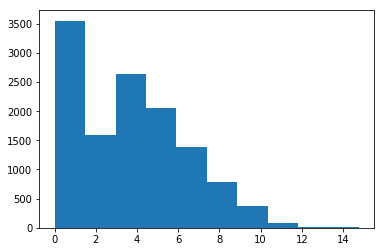

In [98]:
plt.hist(no_dup_df['log_reviews'])

### 2. Drop Movies

In [ ]:
for i in range(len(no_dup_df['systems'])):
    element=(no_dup_df['systems'][i])
    if 'win' not in element and 'mac' not in element and 'linux' not in element:  
        print(element)

### 3. Seperate Windows/Mac/Linux into Individual Bool 0/1 Columns; Repeat IA

In [ ]:
windows=[1 if 'win' in item else 0 for item in no_dup_df.systems]
mac=[1 if 'mac' in item else 0 for item in no_dup_df.systems]
linux=[1 if 'linux' in item else 0 for item in no_dup_df.systems]

In [ ]:
no_dup_df['windows']=pd.Series(windows)
no_dup_df['mac']=pd.Series(mac)
no_dup_df['linux']=pd.Series(linux)

In [ ]:
no_dup_df['windows'] = no_dup_df.windows.astype(int)
no_dup_df['mac'] = no_dup_df.mac.astype(int)
no_dup_df['linux'] = no_dup_df.linux.astype(int)
no_dup_df.info()

# Scraping from Individual Game Pages
Available data:
    1. Genre
    2. Single/Multiplayer
    3. Number of Languages
    4. Developer
    5. Publisher
    6. User-defined tages
    7. Release date (repeat)
    8. Recent Updates
    9. System Requirements

## The Scrape

In [95]:
cols2 = ['title', 'genres', 'players', 'languages', 'developers', 'publisher', 'user_tags']
df_gamepg=pd.DataFrame(columns=cols2, index=[])
link_games=list(no_dup_df.link)


age=date.today()
for link in links_games:
    response=requests.get(link)
    soup = BeautifulSoup(response.text, 'html5lib')
    





df_gamepg.set_index('title', inplace=True)
df_gamepg.rename(columns=lambda x: x.strip())
pd.options.display.max_rows = 4000

In [ ]:
df

In [ ]:
df_gamepg

In [ ]:
no_dup_df

In [ ]:
no_dup_gamepg_df